In [1]:
import numpy as np
from numpy import pi, sin, cos
from numpy.linalg import norm as norm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
def plot_hulls_2D(hulls, closest_points = None, triangles = None):
    
    plt.figure(figsize = (8,8))
    
    for (hull, points) in hulls:
    
        for simplex in hull.simplices:

            xs = [points[0, simplex[0]], points[0, simplex[1]]]
            ys = [points[1, simplex[0]], points[1, simplex[1]]]

            plt.plot(xs, ys, 'b-')
            
    if closest_points != None:
        
        plt.plot([closest_points[0][0], closest_points[1][0]], [closest_points[0][1], closest_points[1][1]])
        
    if triangles != None:
        
        for tri in triangles:
            
            plt.plot([tri[0][0], tri[1][0], tri[2][0], tri[0][0]], [tri[0][1], tri[1][1], tri[2][1], tri[0][1]])
        
    ax = plt.gca()
    ax.set_aspect('equal')    
        
    plt.show()

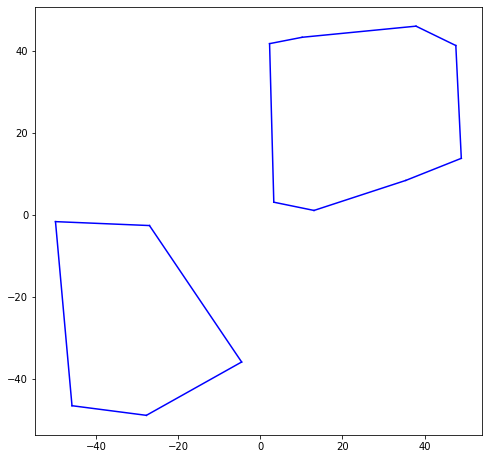

In [3]:
size = 20

points1 = np.random.uniform(-50, 0, (2, size))

hull1 = ConvexHull(points1.T)

points2 = np.random.uniform(0, 50, (2, size))

hull2 = ConvexHull(points2.T)


plot_hulls_2D([(hull1, points1), (hull2, points2)])

In [4]:
def support(points, direction):
    
    best = -1e15
    best_index = 0
    
    for i in range(points.shape[1]):
        
        if direction @ points[:, i] > best:
            
            best = direction @ points[:, i]
            best_index = i
            
    return best_index

In [5]:
direction = np.array([1, 0]).T

print(support(points1, direction))

6


In [6]:
# These are simplex-point tuple pairs
def GJK(hull1, hull2):
    
    # Build up the initial guess simplex
    
    simplex = []
    
    direction = np.array([-1, 0]).T
    
    simplex.append((hull1[1][:, support(hull1[1], direction)] - hull2[1][:, support(hull2[1], -1 * direction)], 
                    support(hull1[1], direction), support(hull2[1], -1 * direction)))
    
    direction = -1 * simplex[0][0]
    
    simplex.append((hull1[1][:, support(hull1[1], direction)] - hull2[1][:, support(hull2[1], -1 * direction)], 
                    support(hull1[1], direction), support(hull2[1], -1 * direction)))
    
    # We now have one line, check which side of the line we should search
    
    def line_normal(p1, p2):
    
        z = np.array([0, 0, 1])

        line = (p2 - p1)

        line = np.array([line[0], line[1], 0]).T

        normal = np.cross(z, line)[0:2]
    
        return normal
    
    
    direction = line_normal(simplex[0][0], simplex[1][0])
    
    # flip direction so it points at the origin
    if simplex[0][0] @ direction > 0:
        
        direction = -1 * direction
        
    
    simplex.append((hull1[1][:, support(hull1[1], direction)] - hull2[1][:, support(hull2[1], -1 * direction)], 
                    support(hull1[1], direction), support(hull2[1], -1 * direction)))
    
    
    print(norm(simplex[0][0]))
    print(norm(simplex[1][0]))
    print(norm(simplex[2][0]))
    
    lastNorms = []
    
    lastNorms.append(norm(simplex[0][0]))
    lastNorms.append(norm(simplex[1][0]))
    lastNorms.append(norm(simplex[2][0]))
        
    for i in range(5):
        
        normal1 = line_normal(simplex[0][0], simplex[2][0])
        
        normal1 = normal1 / norm(normal1)
                              
        if normal1 @ (simplex[1][0] - simplex[0][0]) > 0:
            
            normal1 = -1 * normal1
        
                              
                              
        normal2 = line_normal(simplex[1][0], simplex[2][0])
        
        normal2 = normal2 / norm(normal2)
        
        if normal2 @ (simplex[0][0] - simplex[1][0]) > 0:
            
            normal2 = -1 * normal2
            
            
        originProject1 = normal1 @ (-1*simplex[2][0])
        
        originProject2 = normal2 @ (-1*simplex[2][0])
        
        
        if originProject1 > originProject2:
            
            new_simplex = []
            new_simplex.append(simplex[0])
            new_simplex.append(simplex[2])
            new_simplex.append((hull1[1][:, support(hull1[1], normal1)] - hull2[1][:, support(hull2[1], -1 * normal1)], 
                    support(hull1[1], normal1), support(hull2[1], -1 * normal1)))
            
            
            plot_hulls_2D([hull1, hull2], closest_points=[hull1[1][:, simplex[2][1]], hull2[1][:, simplex[2][2]]], 
                           triangles=[[hull1[1][:, simplex[0][1]], hull1[1][:, simplex[1][1]], hull1[1][:, simplex[2][1]]],
                                      [hull2[1][:, simplex[0][2]], hull2[1][:, simplex[1][2]], hull2[1][:, simplex[2][2]]]])
            
            if new_simplex[2][1] == new_simplex[1][1] and new_simplex[2][2] == new_simplex[1][2] or new_simplex[2][1] == new_simplex[0][1] and new_simplex[2][2] == new_simplex[0][2]:
                break;
            
            simplex = new_simplex
            
            lastNorms.append(norm(new_simplex[2][0]))
    
                              
        else:
            
            new_simplex = []
            new_simplex.append(simplex[1])
            new_simplex.append(simplex[2])
            new_simplex.append((hull1[1][:, support(hull1[1], normal2)] - hull2[1][:, support(hull2[1], -1 * normal2)], 
                    support(hull1[1], normal2), support(hull2[1], -1 * normal2)))
            
            plot_hulls_2D([hull1, hull2], closest_points=[hull1[1][:, simplex[2][1]], hull2[1][:, simplex[2][2]]], 
                           triangles=[[hull1[1][:, simplex[0][1]], hull1[1][:, simplex[1][1]], hull1[1][:, simplex[2][1]]],
                                      [hull2[1][:, simplex[0][2]], hull2[1][:, simplex[1][2]], hull2[1][:, simplex[2][2]]]])
            
            if new_simplex[2][1] == new_simplex[1][1] and new_simplex[2][2] == new_simplex[1][2] or new_simplex[2][1] == new_simplex[0][1] and new_simplex[2][2] == new_simplex[0][2]:
                break;
            
            simplex = new_simplex
        
            lastNorms.append(norm(new_simplex[2][0]))
        
        
        print(norm(simplex[2][0]))
        
    print(norm(simplex[2][0]))
    
    
    def closest_points(p1, p2):
                
        # find closest distance between line and center of the circle
        length_squared = (p2[0] - p1[0]) @ (p2[0] - p1[0])
        
        origin = np.zeros((2,))
        
        t = (origin - p1[0]) @ (p2[0] - p1[0]) / length_squared
        
        t = max(0, min(1, t))
        
        minkow_point = p1[0] + t * (p2[0] - p1[0])
        
        shapeApoint =  hull1[1][:, p1[1]] + t * (hull1[1][:, p2[1]] - hull1[1][:, p1[1]])
        
        shapeBpoint =  hull2[1][:, p1[2]] + t * (hull2[1][:, p2[2]] - hull2[1][:, p1[2]])
                        
        return (minkow_point, shapeApoint, shapeBpoint)
    
    origin = np.zeros((2,))
    
    
    
    normal1 = line_normal(simplex[0][0], simplex[2][0])
        
    normal1 = normal1 / norm(normal1)

    if normal1 @ (simplex[1][0] - simplex[0][0]) > 0:

        normal1 = -1 * normal1



    normal2 = line_normal(simplex[1][0], simplex[2][0])

    normal2 = normal2 / norm(normal2)

    if normal2 @ (simplex[0][0] - simplex[1][0]) > 0:

        normal2 = -1 * normal2


    originProject1 = normal1 @ (-1*simplex[2][0])

    originProject2 = normal2 @ (-1*simplex[2][0])
    
        
    
    if originProject1 > originProject2:
                
        return closest_points(simplex[2], simplex[0])
    
    return closest_points(simplex[2], simplex[1])
                              

92.46360326792974
30.673011741686683
75.01362725884916


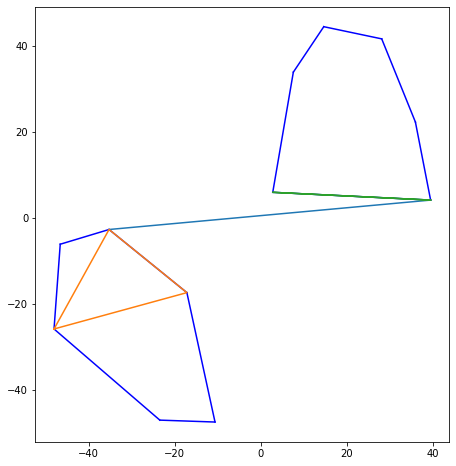

38.99783474493088


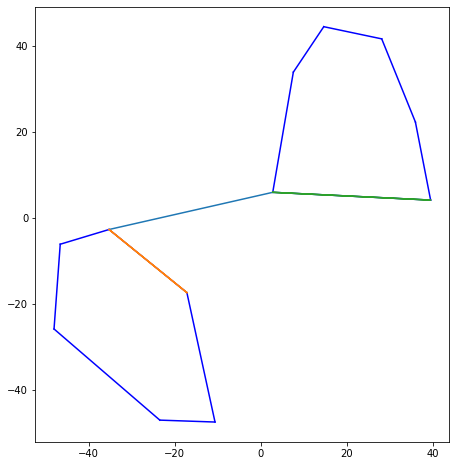

38.99783474493088


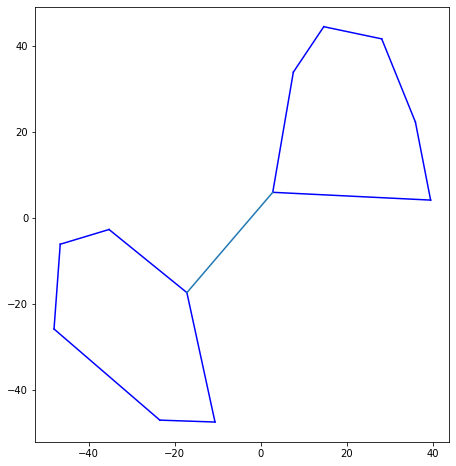

Final Distance was 30.673011741686683


In [11]:
size = 10

np.random.seed(17)

points1 = np.random.uniform(-50, -0, (2, size))

hull1 = ConvexHull(points1.T)

points2 = np.random.uniform(0, 50, (2, size))

hull2 = ConvexHull(points2.T)

(minkow_point, hull1_point, hull2_point) = GJK((hull1, points1), (hull2, points2))

plot_hulls_2D([(hull1, points1), (hull2, points2)], closest_points=[hull1_point, hull2_point])

print("Final Distance was {}".format(norm(minkow_point)))